# Stage 1 - Lesson 3: Feature Engineering for Time Series

This notebook focuses on creating meaningful features for time series prediction using Google stock data. We will:
1. Load and preprocess the data
2. Create rolling features
3. Handle data leakage
4. Remove correlated features
5. Prepare final feature set

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Preprocessing

In [2]:
# Load the data
def load_and_preprocess_data(file_path):
    # Read the data
    df = pd.read_csv(file_path)
    
    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date to ensure proper order
    df = df.sort_values('Date').reset_index(drop=True)
    
    return df

# Load the data
df = load_and_preprocess_data('../../data/googl_data_2020_2025.csv')
print("Data shape:", df.shape)
df.head()

Data shape: (1258, 7)


,Date,Adj Close,Close,High,Low,Open,Volume
0,2020-01-02 00:00:00+00:00,68.186821,68.433998,68.433998,67.324501,67.420502,27278000
1,2020-01-03 00:00:00+00:00,67.830101,68.075996,68.687500,67.365997,67.400002,23408000
2,2020-01-06 00:00:00+00:00,69.638054,69.890503,69.916000,67.550003,67.581497,46768000
3,2020-01-07 00:00:00+00:00,69.503548,69.755501,70.175003,69.578003,70.023003,34330000
4,2020-01-08 00:00:00+00:00,69.998253,70.251999,70.592499,69.631500,69.740997,35314000


## 2. Feature Engineering

We create 2 key types of features:
1. Lag Features (300 days): Captures day-by-day price/volume changes in the past 300 days
   - Example: yesterday's close price helps predict today's price
   
2. Rolling Features (3,5,10, 25, 50,100,250, 365 days windows): Captures market trends
   - Rolling mean: Average price trends (like moving averages)
   - Rolling sum: Cumulative effects, especially useful for volume

All features are shifted by 1 day to avoid data leakage - we only use past data to predict future prices. (The price in next day)


In [3]:
def create_rolling_features(df):
    # Create a copy of the dataframe
    df_features = df.copy()
    
    # List of columns to create features from
    price_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Rolling windows
    windows =range(3,366)
    
    # Dictionary to store all new features
    new_features = {}
    
    # Create rolling features
    for column in price_columns:
        # Past 300 days raw data
        for i in range(1, 301):
            new_features[f'{column}_lag_{i}'] = df_features[column].shift(i)
        
        # Rolling means and sums
        for window in windows:
            new_features[f'{column}_rolling_mean_{window}'] = df_features[column].rolling(window=window).mean().shift(1)
            new_features[f'{column}_rolling_sum_{window}'] = df_features[column].rolling(window=window).sum().shift(1)
    
    # Combine all features at once using pd.concat
    feature_df = pd.concat(new_features, axis=1)
    
    # Combine with original dataframe
    final_df = pd.concat([df_features, feature_df], axis=1)
    
    return final_df

# Create features
df_with_features = create_rolling_features(df)
print("Shape after feature creation:", df_with_features.shape)

Shape after feature creation: (1258, 5137)


## 3. Handle Data Leakage and Create Target

## Data Leakage and Target Creation

### What is Data Leakage?
Data leakage occurs when information from the future accidentally influences our predictions. In stock price prediction:
- If we predict tomorrow's closing price using tomorrow's data, that's leakage
- We must only use information that would be available at prediction time

### How We Prevent It:
1. Target Creation:
   - Target = Next day's closing price
   - Example: To predict Tuesday's close, we use Monday's data

2. Feature Shifting:
   - All features are shifted forward by 1 day
   - When predicting day T, we only use data up to day T-1
   - Remove rows with missing values (NaN) from shifting

Think of it like a real trading scenario: you can't use tomorrow's data to make today's trading decisions!

In [4]:
def prepare_features_and_target(df):
    # Create target (next day's closing price)
    df['target'] = df['Close'].copy()
    
    # Shift features forward by 1 day to prevent data leakage
    feature_columns = [col for col in df.columns if col not in ['Date', 'target']]
    for col in feature_columns:
        df[col] = df[col].shift(1)
    
    # Remove rows with NaN values
    df = df.dropna()
    
    return df

# Prepare features and target
df_prepared = prepare_features_and_target(df_with_features.copy())
print("Shape after preparation:", df_prepared.shape)

Shape after preparation: (892, 5138)


As shown below, Adj Close in 2024-12-24 is a feature for the Close stock price in 2024-12-26.

In [5]:
df_with_features.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,Open_lag_1,Open_lag_2,Open_lag_3,...,Volume_rolling_mean_361,Volume_rolling_sum_361,Volume_rolling_mean_362,Volume_rolling_sum_362,Volume_rolling_mean_363,Volume_rolling_sum_363,Volume_rolling_mean_364,Volume_rolling_sum_364,Volume_rolling_mean_365,Volume_rolling_sum_365
1253,2024-12-24 00:00:00+00:00,196.110001,196.110001,196.110001,193.779999,194.839996,10403300,192.619995,185.779999,191.630005,...,2.802335e+07,1.011643e+10,2.804876e+07,1.015365e+10,2.804374e+07,1.017988e+10,2.803735e+07,1.020559e+10,2.805168e+07,1.023886e+10
1254,2024-12-26 00:00:00+00:00,195.600006,195.600006,196.750000,194.380005,195.149994,12046600,194.839996,192.619995,185.779999,...,2.794716e+07,1.008892e+10,2.797467e+07,1.012683e+10,2.800015e+07,1.016406e+10,2.799528e+07,1.019028e+10,2.798904e+07,1.021600e+10
1255,2024-12-27 00:00:00+00:00,192.759995,192.759995,195.320007,190.649994,194.949997,18891400,195.149994,194.839996,192.619995,...,2.777849e+07,1.002803e+10,2.790324e+07,1.010097e+10,2.793079e+07,1.013888e+10,2.795632e+07,1.017610e+10,2.795159e+07,1.020233e+10
1256,2024-12-30 00:00:00+00:00,191.240005,191.240005,192.550003,189.119995,189.800003,14264700,194.949997,195.149994,194.839996,...,2.774858e+07,1.001724e+10,2.775394e+07,1.004692e+10,2.787841e+07,1.011986e+10,2.790596e+07,1.015777e+10,2.793149e+07,1.019499e+10
1257,2024-12-31 00:00:00+00:00,189.300003,189.300003,191.960007,188.509995,191.080002,17466900,189.800003,194.949997,195.149994,...,2.764264e+07,9.978994e+09,2.771134e+07,1.003150e+10,2.771678e+07,1.006119e+10,2.784101e+07,1.013413e+10,2.786859e+07,1.017203e+10


In [6]:
df_prepared.tail()

,Date,Adj Close,Close,High,Low,Open,Volume,Open_lag_1,Open_lag_2,Open_lag_3,...,Volume_rolling_sum_361,Volume_rolling_mean_362,Volume_rolling_sum_362,Volume_rolling_mean_363,Volume_rolling_sum_363,Volume_rolling_mean_364,Volume_rolling_sum_364,Volume_rolling_mean_365,Volume_rolling_sum_365,target
1253,2024-12-24 00:00:00+00:00,194.630005,194.630005,195.100006,190.149994,192.619995,25675000.0,185.779999,191.630005,195.220001,...,1.012798e+10,2.805029e+07,1.015420e+10,2.804386e+07,1.017992e+10,2.805821e+07,1.021319e+10,2.810270e+07,1.025748e+10,196.110001
1254,2024-12-26 00:00:00+00:00,196.110001,196.110001,196.110001,193.779999,194.839996,10403300.0,192.619995,185.779999,191.630005,...,1.011643e+10,2.804876e+07,1.015365e+10,2.804374e+07,1.017988e+10,2.803735e+07,1.020559e+10,2.805168e+07,1.023886e+10,195.600006
1255,2024-12-27 00:00:00+00:00,195.600006,195.600006,196.750000,194.380005,195.149994,12046600.0,194.839996,192.619995,185.779999,...,1.008892e+10,2.797467e+07,1.012683e+10,2.800015e+07,1.016406e+10,2.799528e+07,1.019028e+10,2.798904e+07,1.021600e+10,192.759995
1256,2024-12-30 00:00:00+00:00,192.759995,192.759995,195.320007,190.649994,194.949997,18891400.0,195.149994,194.839996,192.619995,...,1.002803e+10,2.790324e+07,1.010097e+10,2.793079e+07,1.013888e+10,2.795632e+07,1.017610e+10,2.795159e+07,1.020233e+10,191.240005
1257,2024-12-31 00:00:00+00:00,191.240005,191.240005,192.550003,189.119995,189.800003,14264700.0,194.949997,195.149994,194.839996,...,1.001724e+10,2.775394e+07,1.004692e+10,2.787841e+07,1.011986e+10,2.790596e+07,1.015777e+10,2.793149e+07,1.019499e+10,189.300003


## 4. Remove Correlated Features

### What is Feature Correlation?
Correlation measures how strongly two features are related, ranging from -1 to 1:
- +1: Perfect positive correlation (when A goes up, B goes up)
- -1: Perfect negative correlation (when A goes up, B goes down)
- 0: No correlation (no relationship)

### Why Remove Correlated Features?
1. Redundant Information:
  - Highly correlated features tell us the same thing
  - Example: 5-day and 7-day moving averages often move similarly

2. Model Benefits:
  - Reduces noise in the data
  - Makes model training faster
  - Prevents overfitting
  - Saves memory

### Our Approach:
- Use correlation threshold of 0.95
- Keep one feature from highly correlated pairs
- Focus on keeping the most interpretable features

Think of it like removing duplicate information from your strategy!

In [7]:
def remove_correlated_features(df, threshold=0.95):
    # Calculate correlation matrix
    feature_columns = [col for col in df.columns if col not in ['Date', 'target']]
    correlation_matrix = df[feature_columns].corr().abs()
    
    # Create upper triangle mask
    upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop highly correlated features
    df_uncorrelated = df.drop(columns=to_drop)
    
    print(f"Removed {len(to_drop)} correlated features")
    return df_uncorrelated

# Remove correlated features
df_final = remove_correlated_features(df_prepared)
print("Final shape:", df_final.shape)

Removed 4833 correlated features
Final shape: (892, 305)


## 5. Save Processed Dataset

In [8]:
# Save the processed dataset
df_final.to_csv('../../data/processed_features.csv', index=False)

# Display final feature list
feature_columns = [col for col in df_final.columns if col not in ['Date', 'target']]
print("\nFinal features:")
for feature in feature_columns:
    print(feature)


Final features:
Adj Close
Volume
Volume_lag_1
Volume_lag_2
Volume_lag_3
Volume_lag_4
Volume_lag_5
Volume_lag_6
Volume_lag_7
Volume_lag_8
Volume_lag_9
Volume_lag_10
Volume_lag_11
Volume_lag_12
Volume_lag_13
Volume_lag_14
Volume_lag_15
Volume_lag_16
Volume_lag_17
Volume_lag_18
Volume_lag_19
Volume_lag_20
Volume_lag_21
Volume_lag_22
Volume_lag_23
Volume_lag_24
Volume_lag_25
Volume_lag_26
Volume_lag_27
Volume_lag_28
Volume_lag_29
Volume_lag_30
Volume_lag_31
Volume_lag_32
Volume_lag_33
Volume_lag_34
Volume_lag_35
Volume_lag_36
Volume_lag_37
Volume_lag_38
Volume_lag_39
Volume_lag_40
Volume_lag_41
Volume_lag_42
Volume_lag_43
Volume_lag_44
Volume_lag_45
Volume_lag_46
Volume_lag_47
Volume_lag_48
Volume_lag_49
Volume_lag_50
Volume_lag_51
Volume_lag_52
Volume_lag_53
Volume_lag_54
Volume_lag_55
Volume_lag_56
Volume_lag_57
Volume_lag_58
Volume_lag_59
Volume_lag_60
Volume_lag_61
Volume_lag_62
Volume_lag_63
Volume_lag_64
Volume_lag_65
Volume_lag_66
Volume_lag_67
Volume_lag_68
Volume_lag_69
Volume_la

## 6. Visualization of Feature Correlations

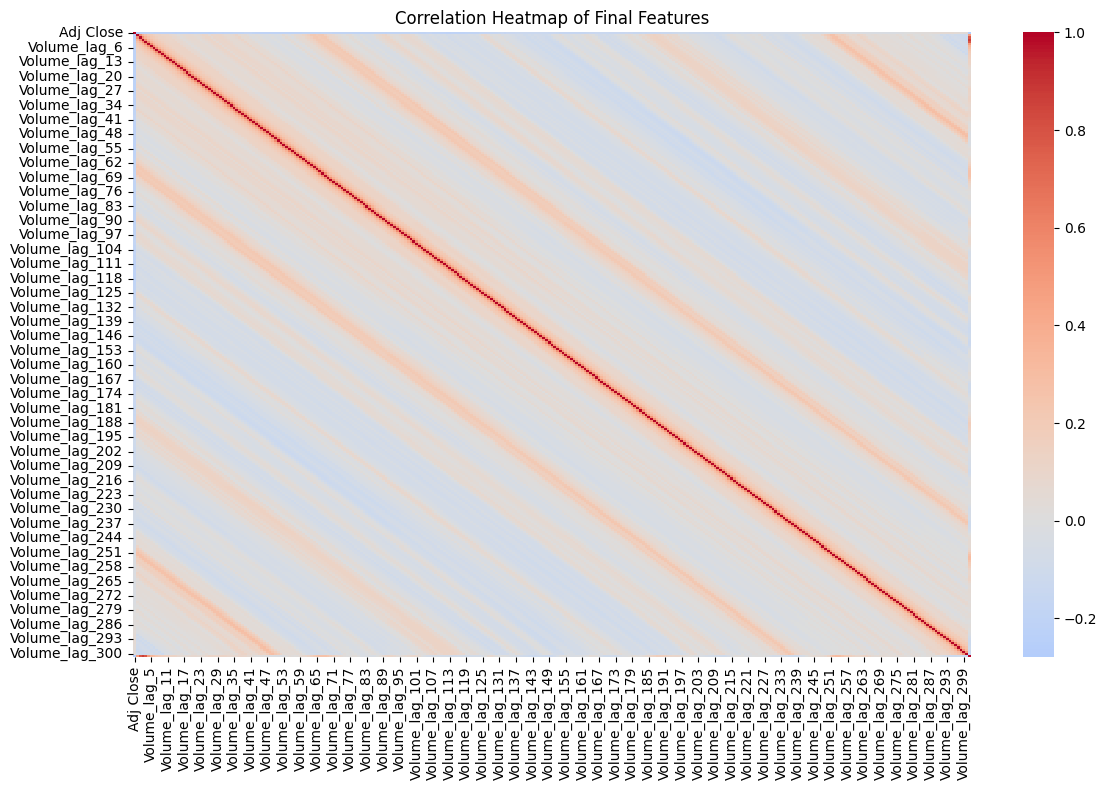

In [9]:
# Plot correlation heatmap of final features
plt.figure(figsize=(12, 8))
correlation_matrix = df_final[feature_columns].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Final Features')
plt.tight_layout()
plt.show()

## Additional Section

# Understanding the Correlation Heatmap

## What is a Correlation Heatmap?

The correlation heatmap visualizes the correlation coefficients between different features in our dataset. The color intensity represents the strength and direction of correlations:
- Red colors indicate positive correlations (closer to +1)
- Blue colors indicate negative correlations (closer to -1)
- White/light colors indicate weak or no correlation (closer to 0)

## Key Observations from Our Heatmap

1. **Volume Lag Features**
   - We can see a strong red diagonal line, which shows the autocorrelation between different lag periods of volume
   - The intensity of red decreases as we move away from the diagonal, indicating that more distant lags have weaker correlations
   - This makes sense because trading volume from consecutive days tends to be more related than volume from days further apart

2. **Rolling Mean Features**
   - Notice the four rows at the bottom (Volume_rolling_mean_10, 25, 60, and 365)
   - These show stronger correlations (darker red) with multiple lag features
   - The rolling means over longer periods (like 365 days) show more consistent correlations across all lag periods

3. **Adj Close and Open Rolling Mean**
   - The Adj Close column shows mostly light colors (weak correlations) with volume-based features
   - This suggests that price and volume might not have strong direct correlations
   - The Open_rolling_mean_365 shows similar patterns to Adj Close

## Why This Matters for Feature Selection

1. **Avoiding Multicollinearity**
   - Features that are highly correlated (dark red) provide redundant information
   - Including highly correlated features can lead to:
     - Unstable model performance
     - Difficulty in interpreting feature importance
     - Overfitting

2. **Feature Selection Strategy**
   - When features are highly correlated, we typically keep one and remove others
   - In our case, we might not need all 30 lag features for volume
   - We might choose to keep:
     - A few key lag periods (e.g., 1, 5, 10 days)
     - Different rolling mean windows as they capture different temporal patterns

3. **Balance Between Short and Long-term Features**
   - The heatmap shows we have both:
     - Short-term dependencies (recent lags)
     - Long-term patterns (rolling means)
   - This gives our model a good mix of features at different time scales

## Technical Implementation Note
The heatmap was created using seaborn's heatmap function with a 'coolwarm' color palette, which is particularly effective for showing correlations as it:
- Uses red for positive correlations
- Uses blue for negative correlations
- Makes it easy to spot patterns and clusters of related features